## Goal is to look across days and get a sense of skill on days that have high vs low soil moisture over CONUS

In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import glob
import cftime
import numpy as np
# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.distributed import Client
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [2]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

def update_leads(x):
    """Converts from time coordinates to lead coordinates.
    I.e., lead days.
    """
    x = x.rename({"time": "lead"})
    x = x.assign_coords(lead=np.arange(x.lead.size).astype(int))
    
    return x

def drop_duplicates_along_all_dims(obj, keep=False):
    deduplicated = obj
    for dim in obj.dims:
        indexes = {dim: ~deduplicated.get_index(dim).duplicated(keep=keep)}
        deduplicated = deduplicated.isel(indexes)
    return deduplicated

In [3]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
   queue="casper",
   walltime="02:00:00",
   account="P93300041",
   memory="4GB",
   resource_spec="select=1:ncpus=1:mem=4GB",
   cores=1,
   processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(8)
client.wait_for_workers(8)


/glade/work/mdfowler/conda-envs/my-npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46883 instead
  warnings.warn(


In [4]:
client

<Client: 'tcp://128.117.208.173:33941' processes=0 threads=0, memory=0 B>

In [ ]:
# client = Client("tcp://128.117.208.181:35051")

In [7]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


In [8]:
model = "cesm2cam6v2"

In [9]:
%%time 
raw  = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.raw.daily.SOILWATER10CM.geospatial.zarr",consolidated=True)
clim = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.climatology.daily.SOILWATER10CM.geospatial.zarr",consolidated=True) 
anom = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.anom.daily.SOILWATER10CM.geospatial.zarr",consolidated=True)



CPU times: user 977 ms, sys: 211 ms, total: 1.19 s
Wall time: 2.44 s


In [7]:
anom

<xarray.Dataset> Size: 131GB
Dimensions:         (member: 11, init: 1168, lead: 46, lat: 192, lon: 288)
Coordinates:
    dayofyear       (init) int64 9kB dask.array<chunksize=(366,), meta=np.ndarray>
  * init            (init) datetime64[ns] 9kB 1999-01-04 ... 2023-10-30
  * lat             (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lead            (lead) int64 368B 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45
  * lon             (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * member          (member) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    SOILWATER_10CM  (member, init, lead, lat, lon) float32 131GB dask.array<chunksize=(11, 1, 46, 181, 288), meta=np.ndarray>

In [10]:
# Use ensemble mean and select just the initialization date 
ensMean_anom = anom.mean(dim='member').isel(lead=0)

In [11]:
# Select just conus
conus  = ensMean_anom.sel(lat=slice(24,52), lon=slice(230,293))

In [12]:
ensMean_anom

<xarray.Dataset> Size: 258MB
Dimensions:         (init: 1168, lat: 192, lon: 288)
Coordinates:
    dayofyear       (init) int64 9kB dask.array<chunksize=(366,), meta=np.ndarray>
  * init            (init) datetime64[ns] 9kB 1999-01-04 ... 2023-10-30
  * lat             (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lead            int64 8B 0
  * lon             (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables:
    SOILWATER_10CM  (init, lat, lon) float32 258MB dask.array<chunksize=(1, 181, 288), meta=np.ndarray>

## For each region, define wet/dry/neutral days 

**Note:** This is drawing super heavily on Samar's code to get regions!

In [13]:
import geopandas as gpd
import xarray as xr
import numpy as np
from rasterio import features
from affine import Affine

In [14]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray
import shapefile
import csv
import os

from eofs.xarray import Eof

import cftime
import nc_time_axis

In [15]:
ds_test = xr.open_dataset("/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/tas_2m_anom_cesm2cam6v2.scenario1_s2s_data.nc")


In [22]:
ds_test

<xarray.Dataset> Size: 14GB
Dimensions:  (lon: 360, lat: 181, lead: 46, time: 1150, date: 1150)
Coordinates:
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lead     (lead) float32 184B 1.0 2.0 3.0 4.0 5.0 ... 43.0 44.0 45.0 46.0
  * time     (time) float32 5kB 7.302e+05 7.302e+05 ... 7.381e+05 7.382e+05
  * date     (date) int32 5kB 19990201 19990208 19990215 ... 20201221 20201228
Data variables:
    anom     (time, lead, lat, lon) float32 14GB ...

In [16]:
## Regrid to the same lat/lon 
regrid_SM = regrid_data(ensMean_anom, ds_test, method=1)

#regrid_SM = regrid_SM.where(regrid_SM.init.dt.month.isin([12,1,2]), drop=True)

In [17]:
data_mean = data.mean()
data_var = data.var()

NameError: name 'data' is not defined

In [17]:
data_var = regrid_SM.var()

In [15]:
def autocorrelation(da, dim='init', max_lag=10):
    da = da - da.mean(dim)
    acf = []
    for lag in range(max_lag + 1):
        shifted = da.roll({dim: -lag}, roll_coords=False)
        # Multiply and take mean over dimension
        acf_lag = (da * shifted).mean(dim) / data_var
        acf.append(acf_lag)
    return xr.concat(acf, dim='lag').assign_coords(lag=range(max_lag + 1))

In [18]:
acf = autocorrelation(regrid_SM, dim='init', max_lag=10)
print(acf)

<xarray.Dataset> Size: 3MB
Dimensions:         (lag: 11, lat: 181, lon: 360)
Coordinates:
    lead            int64 8B 0
  * lat             (lat) float32 724B -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * lon             (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lag             (lag) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    SOILWATER_10CM  (lag, lat, lon) float32 3MB dask.array<chunksize=(1, 181, 360), meta=np.ndarray>


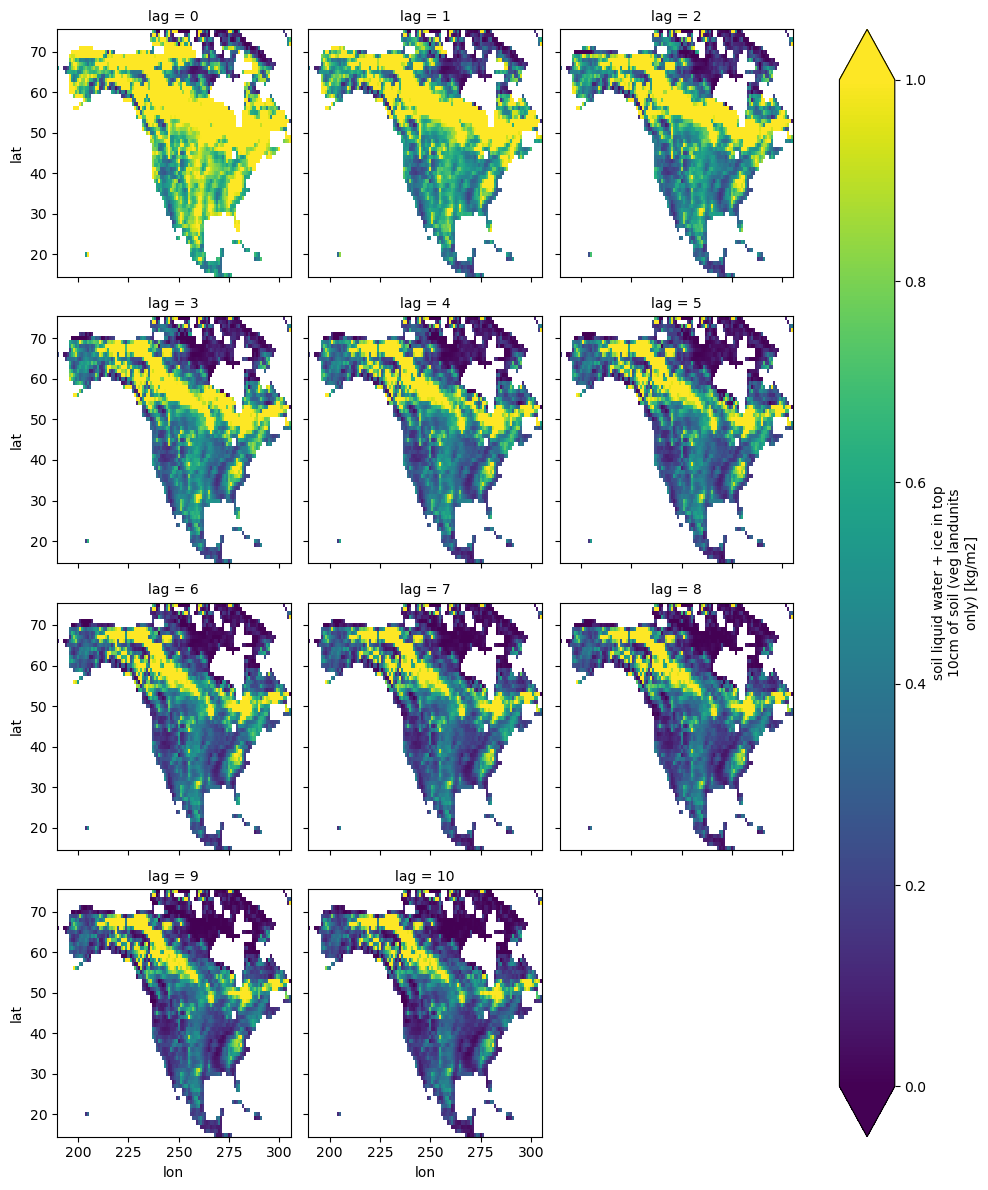

In [19]:
acf.SOILWATER_10CM.sel(lat=slice(15.0, 75.0),lon=slice(190.0, 305.0)).plot(col="lag",vmin=0,vmax=1,col_wrap=3)

In [20]:
acf.SOILWATER_10CM.min().compute()

KeyboardInterrupt: 

In [ ]:
acf.SOILWATER_10CM.max().compute()

In [ ]:
acf.SOILWATER_10CM.sel(lat=40,lon=265).plot()

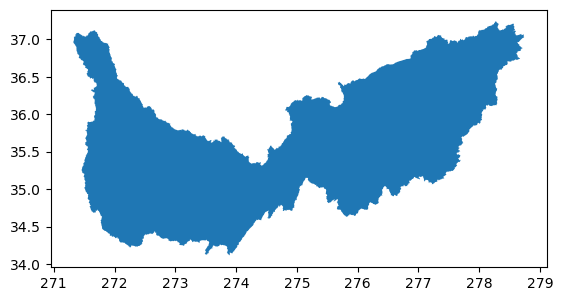

In [18]:
import shapely.ops

# shapefiles = [
#     'US_Northeast.shp', 'US_NorthernRockies.shp', 'US_Northwest.shp', 'US_OhioValley.shp', 'US_South.shp', 
#     'US_Southeast.shp', 'US_Southwest.shp', 'US_UpperMidwest.shp', 'US_West.shp'
# ]
# shapefiles = [
#     'WBDHU2_01.shp', 'WBDHU2_02.shp', 'WBDHU2_03.shp', 'WBDHU2_04.shp', 'WBDHU2_05.shp', 
#     'WBDHU2_06.shp', 'WBDHU2_07.shp', 'WBDHU2_08.shp', 'WBDHU2_09.shp', 'WBDHU2_10.shp',
#     'WBDHU2_11.shp', 'WBDHU2_12.shp', 'WBDHU2_13.shp', 'WBDHU2_14.shp', 'WBDHU2_15.shp',
#     'WBDHU2_16.shp', 'WBDHU2_17.shp', 'WBDHU2_18.shp', 'WBDHU2_19.shp', 'WBDHU2_20.shp',
#     'WBDHU2_21.shp', 'WBDHU2_22.shp',
# ]
shapefiles = [
    'WBDHU2_01.shp', 'WBDHU2_02.shp', 'WBDHU2_03.shp', 'WBDHU2_04.shp', 'WBDHU2_05.shp', 
    'WBDHU2_06.shp', 'WBDHU2_07.shp', 'WBDHU2_08.shp', 'WBDHU2_09.shp', 'WBDHU2_10.shp',
    'WBDHU2_11.shp', 'WBDHU2_12.shp', 'WBDHU2_13.shp', 'WBDHU2_14.shp', 'WBDHU2_15.shp',
    'WBDHU2_16.shp', 'WBDHU2_17.shp', 'WBDHU2_18.shp', 'WBDHU2_19.shp', 
]

# shapefile_dir = '/glade/u/home/mdfowler/Analysis/S2S/SamarFiles/'
shapefile_dir = '/glade/work/mdfowler/shpFiles_fromSamar'

# Shift -180 to 180 longitudes to 0 to 360 - match with LENS2
def shift_geometry_longitudes(geometry):
    def shift_point(lon, lat):
        return ((lon + 360) if lon < 0 else lon, lat)

    return geometry.apply(lambda geom: shapely.ops.transform(
        lambda x, y: shift_point(x, y), geom)
    )

# Read shapefiles and shift longitudes
gdfs = []
for shapefile in shapefiles:
    gdf = gpd.read_file(os.path.join(shapefile_dir, shapefile))
    if gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')                                 # Double check if this is the right projection for LENS
    gdf['geometry'] = shift_geometry_longitudes(gdf['geometry'])
    gdfs.append(gdf)

# Assign each region
US_HUC01 = gdfs[0]
US_HUC02 = gdfs[1]
US_HUC03 = gdfs[2]
US_HUC04 = gdfs[3]
US_HUC05 = gdfs[4]
US_HUC06 = gdfs[5]
US_HUC07 = gdfs[6]
US_HUC08 = gdfs[7]
US_HUC09 = gdfs[8]
US_HUC10 = gdfs[9]
US_HUC11 = gdfs[10]
US_HUC12 = gdfs[11]
US_HUC13 = gdfs[12]
US_HUC14 = gdfs[13]
US_HUC15 = gdfs[14]
US_HUC16 = gdfs[15]
US_HUC17 = gdfs[16]
US_HUC18 = gdfs[17]
US_HUC19 = gdfs[18]
# US_HUC20 = gdfs[19]
# US_HUC21 = gdfs[20]
# US_HUC22 = gdfs[21]

input_domain_name = "WBDHU2_06"
input_domain = US_HUC06
# input_domain = gpd.GeoDataFrame(pd.concat([US_West, US_NW], ignore_index=True))           #If want to combine multiple regions

input_domain.plot();

In [19]:
## some necessary first steps:
variable = regrid_SM.SOILWATER_10CM

# Rename dimensions to match what rioxarray expects
variable = variable.rename({'lat': 'y', 'lon': 'x'})

# Assign CRS
variable.rio.write_crs('EPSG:4326', inplace=True)


<xarray.DataArray 'SOILWATER_10CM' (init: 1168, y: 181, x: 360)> Size: 304MB
dask.array<chunked_aware_interpnd, shape=(1168, 181, 360), dtype=float32, chunksize=(1, 181, 360), chunktype=numpy.ndarray>
Coordinates:
    dayofyear    (init) int64 9kB dask.array<chunksize=(366,), meta=np.ndarray>
  * init         (init) datetime64[ns] 9kB 1999-01-04 1999-01-11 ... 2023-10-30
    lead         int64 8B 0
  * y            (y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * x            (x) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 8B 0
Attributes:
    cell_methods:  time: mean
    long_name:     soil liquid water + ice in top 10cm of soil (veg landunits...
    units:         kg/m2

In [21]:
domainNames = ['US_HUC01', 'US_HUC02', 'US_HUC03', 'US_HUC04', 'US_HUC05', 'US_HUC06', 'US_HUC07', 'US_HUC08',
               'US_HUC09', 'US_HUC10', 'US_HUC11', 'US_HUC12', 'US_HUC13', 'US_HUC14', 'US_HUC15', 'US_HUC16', 
               'US_HUC17', 'US_HUC18', 'US_HUC19']

shapefiles = [
    'WBDHU2_01.shp', 'WBDHU2_02.shp', 'WBDHU2_03.shp', 'WBDHU2_04.shp', 'WBDHU2_05.shp', 
    'WBDHU2_06.shp', 'WBDHU2_07.shp', 'WBDHU2_08.shp', 'WBDHU2_09.shp', 'WBDHU2_10.shp',
    'WBDHU2_11.shp', 'WBDHU2_12.shp', 'WBDHU2_13.shp', 'WBDHU2_14.shp', 'WBDHU2_15.shp',
    'WBDHU2_16.shp', 'WBDHU2_17.shp', 'WBDHU2_18.shp', 'WBDHU2_19.shp', 
]


In [24]:
da_rolled = variable.rolling(init=3, center=False).mean().isel(init=slice(2, None))
#da_rolled = da_rolled.compute()
#da_rolled = da_rolled.dropna(dim='init')

In [25]:
da_rolled

<xarray.DataArray 'SOILWATER_10CM' (init: 1166, y: 181, x: 360)> Size: 304MB
dask.array<getitem, shape=(1166, 181, 360), dtype=float32, chunksize=(3, 181, 360), chunktype=numpy.ndarray>
Coordinates:
    dayofyear    (init) int64 9kB dask.array<chunksize=(364,), meta=np.ndarray>
  * init         (init) datetime64[ns] 9kB 1999-01-18 1999-01-25 ... 2023-10-30
    lead         int64 8B 0
  * y            (y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * x            (x) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    spatial_ref  int64 8B 0
Attributes:
    cell_methods:  time: mean
    long_name:     soil liquid water + ice in top 10cm of soil (veg landunits...
    units:         kg/m2

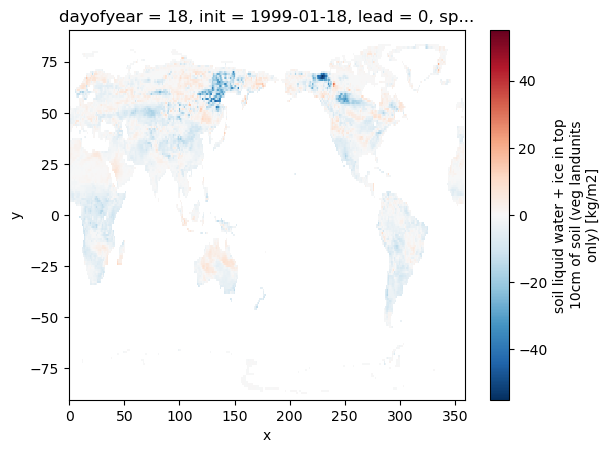

In [116]:
da_rolled.isel(init=0).plot()

Working on domain...  US_HUC01


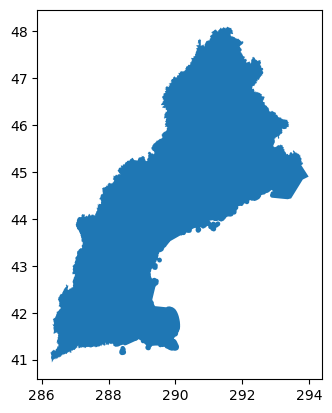

Loading data... give it a second...
For region     US_HUC01: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC02


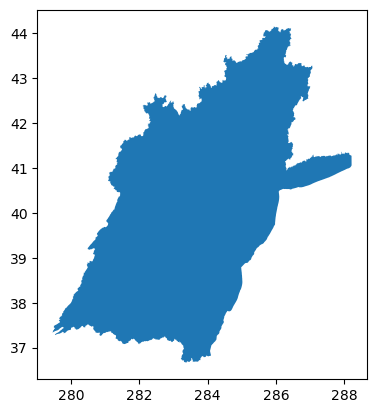

Loading data... give it a second...
For region     US_HUC02: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC03


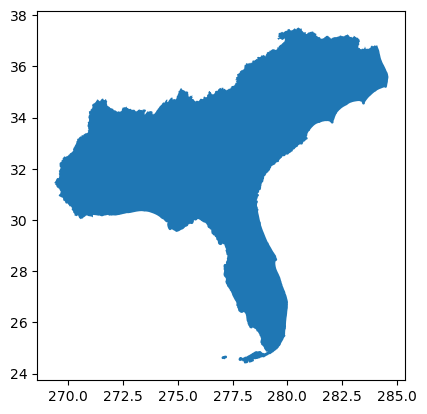

Loading data... give it a second...
For region     US_HUC03: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC04


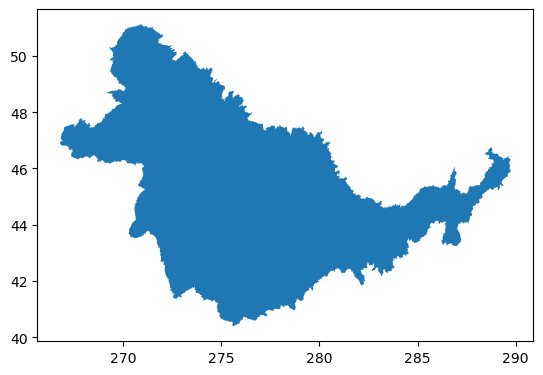

Loading data... give it a second...
For region     US_HUC04: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC05


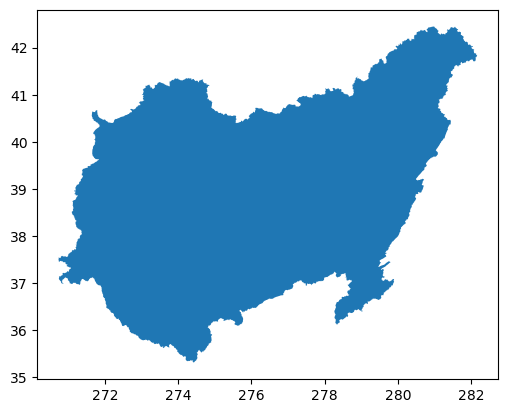

Loading data... give it a second...
For region     US_HUC05: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC06


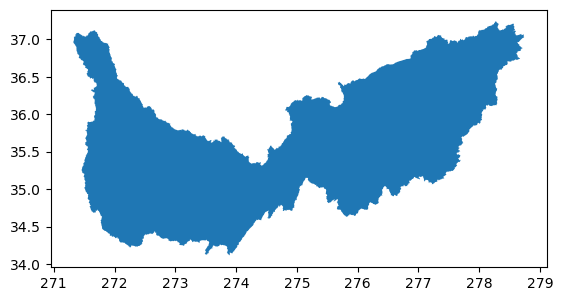

Loading data... give it a second...
For region     US_HUC06: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC07


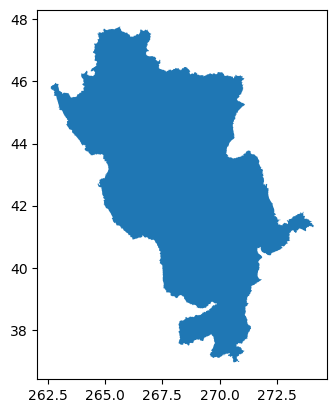

Loading data... give it a second...
For region     US_HUC07: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC08


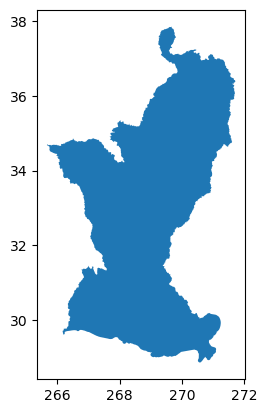

Loading data... give it a second...
For region     US_HUC08: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC09


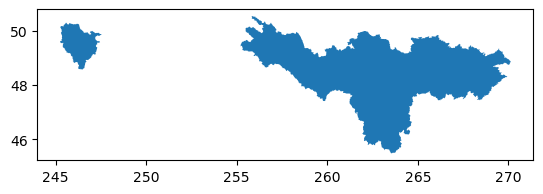

Loading data... give it a second...
For region     US_HUC09: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC10


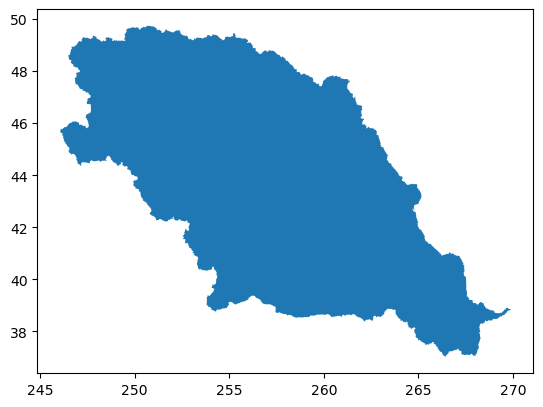

Loading data... give it a second...
For region     US_HUC10: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC11


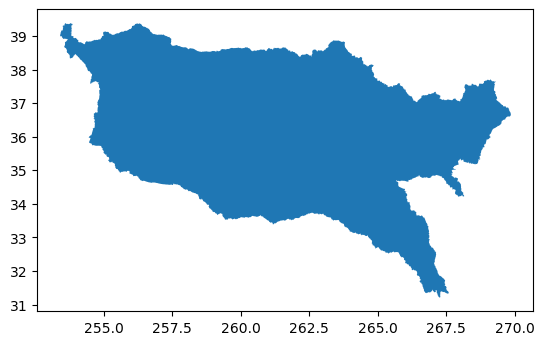

Loading data... give it a second...
For region     US_HUC11: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC12


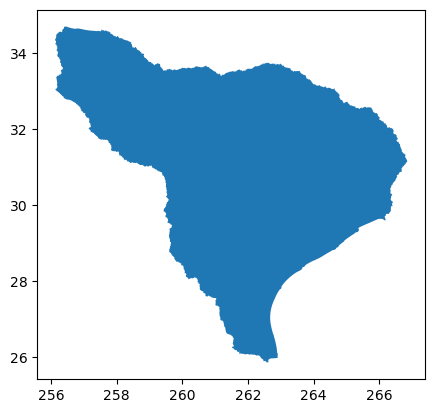

Loading data... give it a second...
For region     US_HUC12: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC13


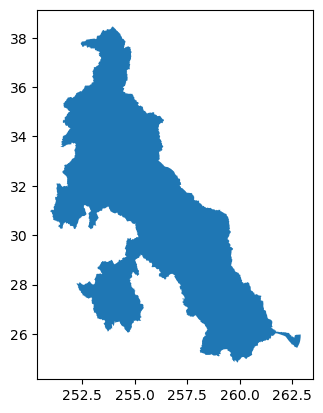

Loading data... give it a second...
For region     US_HUC13: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC14


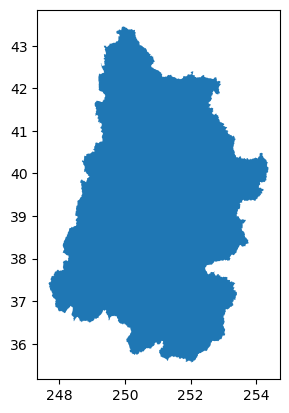

Loading data... give it a second...
For region     US_HUC14: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC15


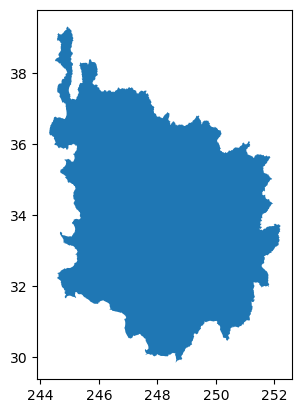

Loading data... give it a second...
For region     US_HUC15: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC16


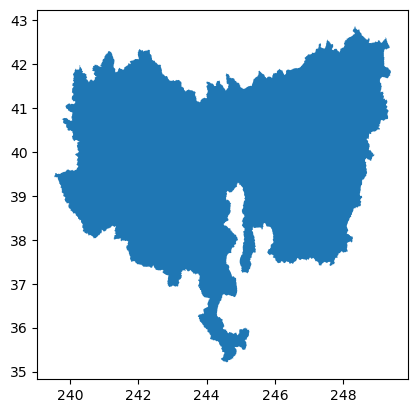

Loading data... give it a second...
For region     US_HUC16: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC17


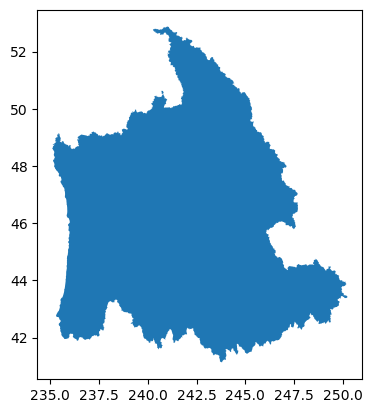

Loading data... give it a second...
For region     US_HUC17: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC18


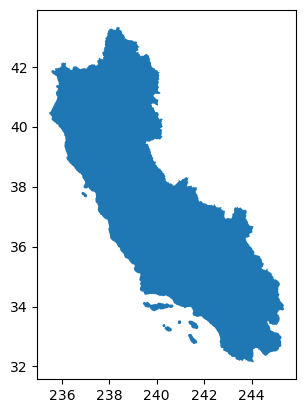

Loading data... give it a second...
For region     US_HUC18: 
    292 dry days
    292 wet days
    584 neutral days

Working on domain...  US_HUC19


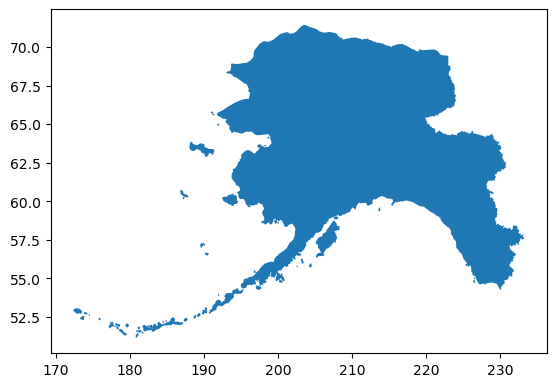

Loading data... give it a second...
For region     US_HUC19: 
    292 dry days
    292 wet days
    584 neutral days



In [22]:
#domainNames = ['US_NE']

categories_all = np.full([len(domainNames), len(variable.init.values)], '             ')

for iReg in range(len(domainNames)):
    print('Working on domain... ', domainNames[iReg])
    
    input_domain = gdfs[iReg]
    input_domain.plot(); plt.show();
    
    ## Step 0: Mask the data
    # Clip using shapefile geometry
    # variable_domain = da_rolled.rio.clip(
    variable_domain = variable.rio.clip(
        input_domain.geometry.apply(mapping),
        input_domain.crs,
        all_touched=False             #Select all gridcells touching the shapefile bounds or not
    # ).weighted(np.cos(np.deg2rad(da_rolled.y))).mean(("y", "x")).compute()
    ).weighted(np.cos(np.deg2rad(variable.y))).mean(("y", "x")).compute()
    #).mean(("x","y"))
    
    ## MDF:  
    #     *~*~* This is where the magic happens *~*~*
    
    # Step 1:
    # Get high/low definition of soil moisture at each point
    # tercile_33 = variable_domain.chunk(dict(init=-1)).quantile(1/3, dim='init')
    # tercile_67 = variable_domain.chunk(dict(init=-1)).quantile(2/3, dim='init')
    quantile_25 = variable_domain.chunk(dict(init=-1)).quantile(1/4, dim='init')
    quantile_75 = variable_domain.chunk(dict(init=-1)).quantile(3/4, dim='init')
    
    # Step 2: 
    # Create categorical data: 0=dry, 1=neutral, 2=wet
    # Using xarray's where function for efficient conditional assignment
    soil_categories = xr.where(
        variable_domain<= quantile_25, 0,  # dry
        xr.where( 
            variable_domain >= quantile_75, 2,  # wet
            1  # neutral (middle tercile)
        )).compute()
    
    # Step 3: 
    # Check if enough of domain is above/below threshold 
    print('Loading data... give it a second...')
    soilCats = soil_categories.values
    
    #   3.1: Flatten arrays 
    n_times = soilCats.shape[0]
    #n_times, n_lat, n_lon = soilCats.shape
    #domain_reshaped = soilCats
    #domain_reshaped = soilCats.reshape(n_times, n_lat * n_lon)
    
    #   3.2: Set threshold 
    #nSpace_valid = len(np.isfinite(domain_reshaped[0,:]))
    #threshold = 0.5 
    
    #   3.3: Tag data 
    # reg_category = np.full([n_times], '             ')
    
    for iT in range(n_times):
        #iDry     = np.where(domain_reshaped[iT,:]==0)[0]
        #iNeutral = np.where(domain_reshaped[iT,:]==1)[0]
        #iWet     = np.where(domain_reshaped[iT,:]==2)[0]

        if soil_categories[iT]==0:
        #if (len(iDry)>=(nSpace_valid*threshold)):
            categories_all[iReg, iT] = 'dry'
        elif soil_categories[iT]==2:
        #elif (len(iWet)>=(nSpace_valid*threshold)):
            categories_all[iReg, iT] = 'wet'
        elif soil_categories[iT]==1:
        #elif (len(iNeutral)>=(nSpace_valid*threshold)):
            categories_all[iReg, iT] = 'neutral'
        else: 
            categories_all[iReg, iT] = 'mixed'

    print('For region %12s: \n %6i dry days\n %6i wet days\n %6i neutral days\n' % 
          (domainNames[iReg], 
           len(np.where(categories_all[iReg,:]=='dry')[0]),
           len(np.where(categories_all[iReg,:]=='wet')[0]), 
           len(np.where(categories_all[iReg,:]=='neutral')[0])) 
         )



In [23]:
cat_DS = xr.Dataset(
    data_vars = dict( 
        soilTercileCategory  = (['region','init'], categories_all),
    ), 
    coords = dict(
        region=domainNames,
        init=variable.init.values, 
    )
)

In [24]:
cat_DS.to_netcdf('catDS_SMterciles_basins_quant-aft-regavg.nc')


## Can I use Abby's scripts to get ACC for each region? 

I would need to... 
- Get the temperature anomalies for each biweekly period for the inits labeled wet/dry/neutral/mixed for each region
- Get that in obs too
- Compute ACC? 

**This part is from Abby's script 4_**

In [52]:
def make_biweekly(hind):
    init_w12 = hind.sel(lead=range(1, 1 + 15)).mean(dim='lead', skipna=False)
    init_w34 = hind.sel(lead=range(16, 16 + 15)).mean(dim='lead', skipna=False)
    init_w56 = hind.sel(lead=range(31, 31 + 14)).mean(dim='lead', skipna=False)
    hind_bw = xr.concat([init_w12, init_w34, init_w56], dim='lead')
    hind_bw['lead'] = [1, 15, 31] # lead represents first day of biweekly aggregate
    hind_bw['lead'].attrs['units'] = 'days'
    return hind_bw

In [50]:
model = "CESM2_climoATM"
data = "anom" #raw or anom or climatology

hinda = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+"."+data+".daily.geospatial.zarr/", consolidated=True).astype('float32')
hinda["lead"] = range(0,46)

In [53]:
hind_bw = make_biweekly(hinda)

Need biweekly verification data too! 

In [ ]:
verif = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/OBS_SUBX.raw.biweekly.geospatial.zarr/", consolidated=True).astype('float32')